In this script we're plotting the gender counts in each genre across time to see trends in data. The goal is to evaluate whether our data supports such an analysis.

In [58]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind, ks_2samp, t, pointbiserialr
import json

In [59]:
# Import clean character metadata
character_meta_genre = pd.read_csv('./data/character_meta_genre.csv')
character_meta_genre.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Genres Reduced
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,"['Adventure', 'Action', 'Western', 'Science Fi..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,"['Adventure', 'Action', 'Western', 'Science Fi..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,"['Adventure', 'Action', 'Western', 'Science Fi..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,"['Adventure', 'Action', 'Western', 'Science Fi..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,"['Adventure', 'Action', 'Western', 'Science Fi..."


In [60]:
# Function to safely convert string representations of lists into actual lists
def string_to_list(list_string):
    try:
        # This safely evaluates a string as a list
        return ast.literal_eval(list_string)
    except ValueError:
        # In case of error (e.g., empty strings), return an empty list
        return []

In [61]:
character_meta_genre['Genres Reduced'] = character_meta_genre['Genres Reduced'].apply(string_to_list)

character_meta_genre.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Genres Reduced
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,"[Adventure, Action, Western, Science Fiction, ..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,"[Adventure, Action, Western, Science Fiction, ..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,"[Adventure, Action, Western, Science Fiction, ..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,"[Adventure, Action, Western, Science Fiction, ..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,"[Adventure, Action, Western, Science Fiction, ..."


### Step 1: Check gender missing values

In [62]:
# Are wikipedia movie ID's unique?
if character_meta_genre['Wikipedia movie ID'].nunique() == character_meta_genre['Freebase movie ID'].nunique():
    print(f"The wikipedia IDs are unique for each movie")


The wikipedia IDs are unique for each movie


In [63]:
# Also how many nan values do we have in the gender column?
print(f"We have {character_meta_genre['Actor gender'].isna().sum()} missing genders")

# What proportion of the genders is this?
print(f"This is {(character_meta_genre['Actor gender'].isna().sum()/character_meta_genre['Actor gender'].count())*100:.2f}% of values")

# Is this acceptable
print(f"Is this acceptable? Assume it is because it's small?")

We have 45609 missing genders
This is 11.26% of values
Is this acceptable? Assume it is because it's small?


In [64]:
# Keep only wikipedia IDs, movie release date, actor gender and genre
character_meta_genre_ = character_meta_genre[['Wikipedia movie ID', 
                                             'Movie release date', 
                                             'Actor gender', 
                                             'Genres Reduced']]

# Visualise result
character_meta_genre_.head()

,Wikipedia movie ID,Movie release date,Actor gender,Genres Reduced
0,975900,2001-08-24,F,"[Adventure, Action, Western, Science Fiction, ..."
1,975900,2001-08-24,F,"[Adventure, Action, Western, Science Fiction, ..."
2,975900,2001-08-24,M,"[Adventure, Action, Western, Science Fiction, ..."
3,975900,2001-08-24,M,"[Adventure, Action, Western, Science Fiction, ..."
4,975900,2001-08-24,F,"[Adventure, Action, Western, Science Fiction, ..."


In [65]:
# How many nan values in genre?
print(f"Number of missing values in genres: {character_meta_genre_['Genres Reduced'].isna().sum()}")
print(f"The percentage of missing genres is: {character_meta_genre_['Genres Reduced'].isna().sum()/character_meta_genre_['Genres Reduced'].count()*100:.2f}%")

if character_meta_genre_['Genres Reduced'].isna().sum()/character_meta_genre_['Genres Reduced'].count()*100<15:
    print(f"We assume percentage of missing values negligible and we drop them")

Number of missing values in genres: 0
The percentage of missing genres is: 0.00%
We assume percentage of missing values negligible and we drop them


In [66]:
# Drop missing genre rows
character_meta_genre_ = character_meta_genre_[character_meta_genre_['Genres Reduced'].notna()]

In [67]:
# We want to group by genre. We first need to convert lists to tuples bc lists are mutable
character_meta_genre_['Genres Reduced'] = character_meta_genre_['Genres Reduced'].apply(tuple)

character_meta_genre_.head()

,Wikipedia movie ID,Movie release date,Actor gender,Genres Reduced
0,975900,2001-08-24,F,"(Adventure, Action, Western, Science Fiction, ..."
1,975900,2001-08-24,F,"(Adventure, Action, Western, Science Fiction, ..."
2,975900,2001-08-24,M,"(Adventure, Action, Western, Science Fiction, ..."
3,975900,2001-08-24,M,"(Adventure, Action, Western, Science Fiction, ..."
4,975900,2001-08-24,F,"(Adventure, Action, Western, Science Fiction, ..."


In [68]:
# Function that transforms all our dates into one format that maintains only the year
def release_date_format(value): 
    if isinstance(value, str) and value.startswith(('18', '19', '20')): # no movies before 1800
        return value[:4]
    else:
        return pd.NA 

In [69]:
character_meta_genre_['Movie release date'] = character_meta_genre_['Movie release date'].apply(release_date_format)

character_meta_genre_.head()

,Wikipedia movie ID,Movie release date,Actor gender,Genres Reduced
0,975900,2001,F,"(Adventure, Action, Western, Science Fiction, ..."
1,975900,2001,F,"(Adventure, Action, Western, Science Fiction, ..."
2,975900,2001,M,"(Adventure, Action, Western, Science Fiction, ..."
3,975900,2001,M,"(Adventure, Action, Western, Science Fiction, ..."
4,975900,2001,F,"(Adventure, Action, Western, Science Fiction, ..."


In [70]:
# Drop nan
print(f"Number of missing values in dates: {(character_meta_genre_['Movie release date'].isna().sum()/character_meta_genre_['Movie release date'].count())*100:.4f}%")

if (character_meta_genre_['Movie release date'].isna().sum()/character_meta_genre_['Movie release date'].count())*100<15:
    print(f"The number of missing data in dates is insignicant so we'll drop them")
    character_meta_genre_ = character_meta_genre_[character_meta_genre_['Movie release date'].notna()]


Number of missing values in dates: 2.2716%
The number of missing data in dates is insignicant so we'll drop them


In [72]:
character_meta_genre_['Movie release date'] = character_meta_genre_['Movie release date'].apply(lambda x: int(x))

In [74]:
# Explode the genre tuples
character_meta_genre_exploded = character_meta_genre_.explode('Genres Reduced')

character_meta_genre_exploded.head()

,Wikipedia movie ID,Movie release date,Actor gender,Genres Reduced
0,975900,2001,F,Adventure
0,975900,2001,F,Action
0,975900,2001,F,Western
0,975900,2001,F,Science Fiction
0,975900,2001,F,Thriller


In [78]:
# function to count number of females 
def count_females(column):
    f_count = column.value_counts()['F']
    return f_count

# function to count number of males
def count_males(column):
    m_count = column.value_counts()['M']
    return m_count


In [84]:

# For each genre and year count the number of females and males
character_meta_genre_year = character_meta_genre_exploded.groupby(['Movie release date', 
                                                                   'Genres Reduced']).agg(Female_count_year = ('Actor gender',  
                                                                                                lambda x: (x == 'F').sum()),
                                                                                            Male_count_year = ('Actor gender',
                                                                                                lambda x: (x == 'M').sum())).reset_index()

character_meta_genre_year.head()

,Movie release date,Genres Reduced,Female_count_year,Male_count_year
0,1888,Black and White,2,2
1,1888,Independent,2,2
2,1888,Short Film,2,2
3,1888,Silent,2,2
4,1891,Independent,0,1


In [93]:
# Make list of unique genres
unique_genres = set(character_meta_genre_year['Genres Reduced'].tolist())

# Group by genre
#For each genre create a new subplot
character_meta_genre_year_final= character_meta_genre_year.groupby('Genres Reduced').agg(Release_date_list = ('Movie release date', lambda x: list(x)),
                                                                                   F_count_list = ('Female_count_year', lambda x: list(x)),
                                                                                    M_count_list = ('Male_count_year', lambda x: list(x) )).reset_index()

character_meta_genre_year_final.head()


,Genres Reduced,Release_date_list,F_count_list,M_count_list
0,Action,"[1903, 1908, 1909, 1912, 1913, 1914, 1915, 191...","[1, 2, 0, 4, 5, 2, 6, 5, 2, 3, 3, 11, 3, 6, 6,...","[2, 7, 1, 11, 12, 5, 19, 12, 11, 13, 7, 23, 18..."
1,Adult,"[1899, 1920, 1927, 1933, 1938, 1940, 1942, 194...","[1, 0, 1, 5, 3, 5, 4, 1, 1, 3, 3, 18, 18, 3, 8...","[0, 2, 4, 3, 3, 5, 10, 3, 0, 1, 14, 14, 34, 8,..."
2,Adventure,"[1902, 1903, 1904, 1907, 1910, 1911, 1912, 191...","[2, 1, 0, 2, 1, 0, 1, 6, 9, 9, 5, 4, 10, 8, 27...","[7, 1, 1, 2, 0, 5, 1, 10, 16, 33, 12, 9, 10, 1..."
3,Animated,"[1931, 1933, 1935, 1939, 1940, 1941, 1942, 194...","[1, 1, 3, 2, 1, 6, 9, 1, 3, 2, 3, 3, 2, 3, 2, ...","[0, 2, 6, 6, 6, 14, 26, 5, 11, 7, 6, 9, 4, 4, ..."
4,Animation,"[1906, 1908, 1913, 1914, 1921, 1923, 1924, 192...","[0, 1, 0, 0, 2, 0, 2, 2, 1, 4, 3, 11, 24, 15, ...","[1, 0, 1, 4, 1, 1, 3, 4, 8, 8, 0, 2, 19, 11, 6..."


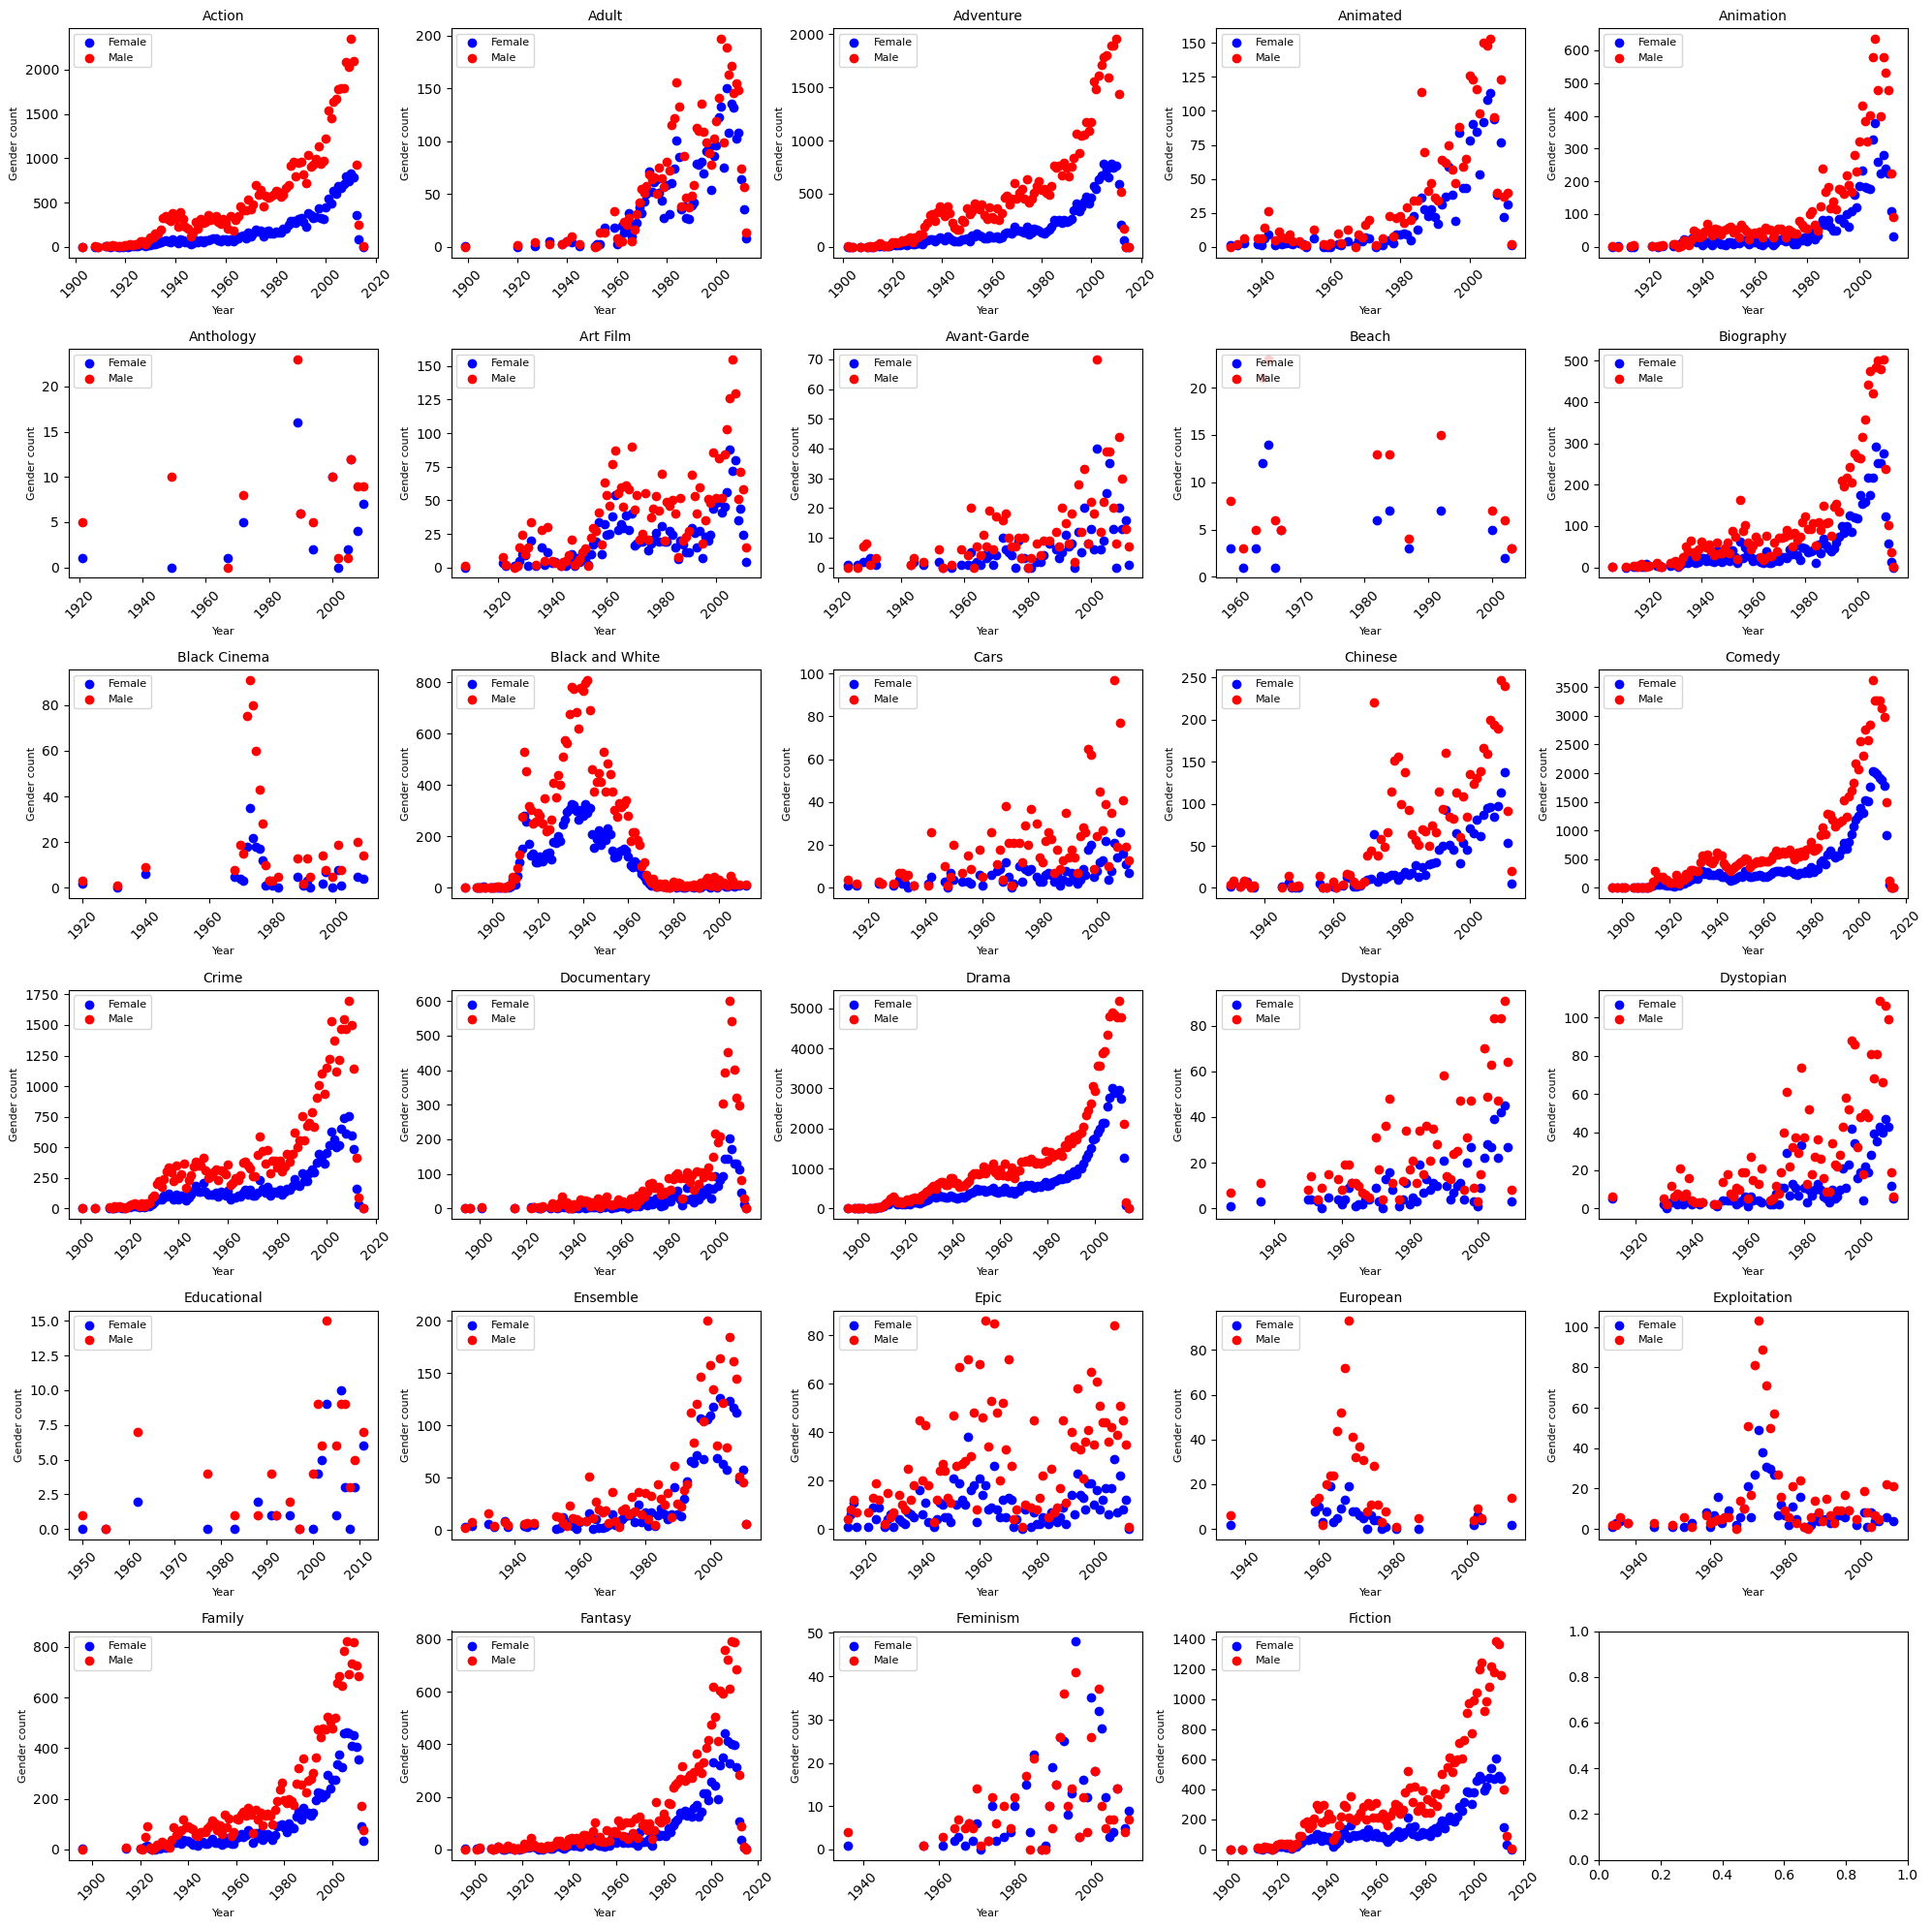

In [105]:
# Make function to create plot for subset of genres because we have 77 of them
def plot_genres(data, start_idx, end_idx):
    fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20,20))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    for (idx, row), ax in zip(data.iloc[start_idx:end_idx].iterrows(), axs.flatten()):
        ax.scatter(row['Release_date_list'], row['F_count_list'], color='blue', label='Female')
        ax.scatter(row['Release_date_list'], row['M_count_list'], color='red', label='Male')
        ax.set_title(row['Genres Reduced'], fontsize=10)
        ax.set_xlabel('Year', fontsize=8)
        ax.set_ylabel('Gender count', fontsize=8)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_1 = plot_genres(character_meta_genre_year_final, 0, 29)

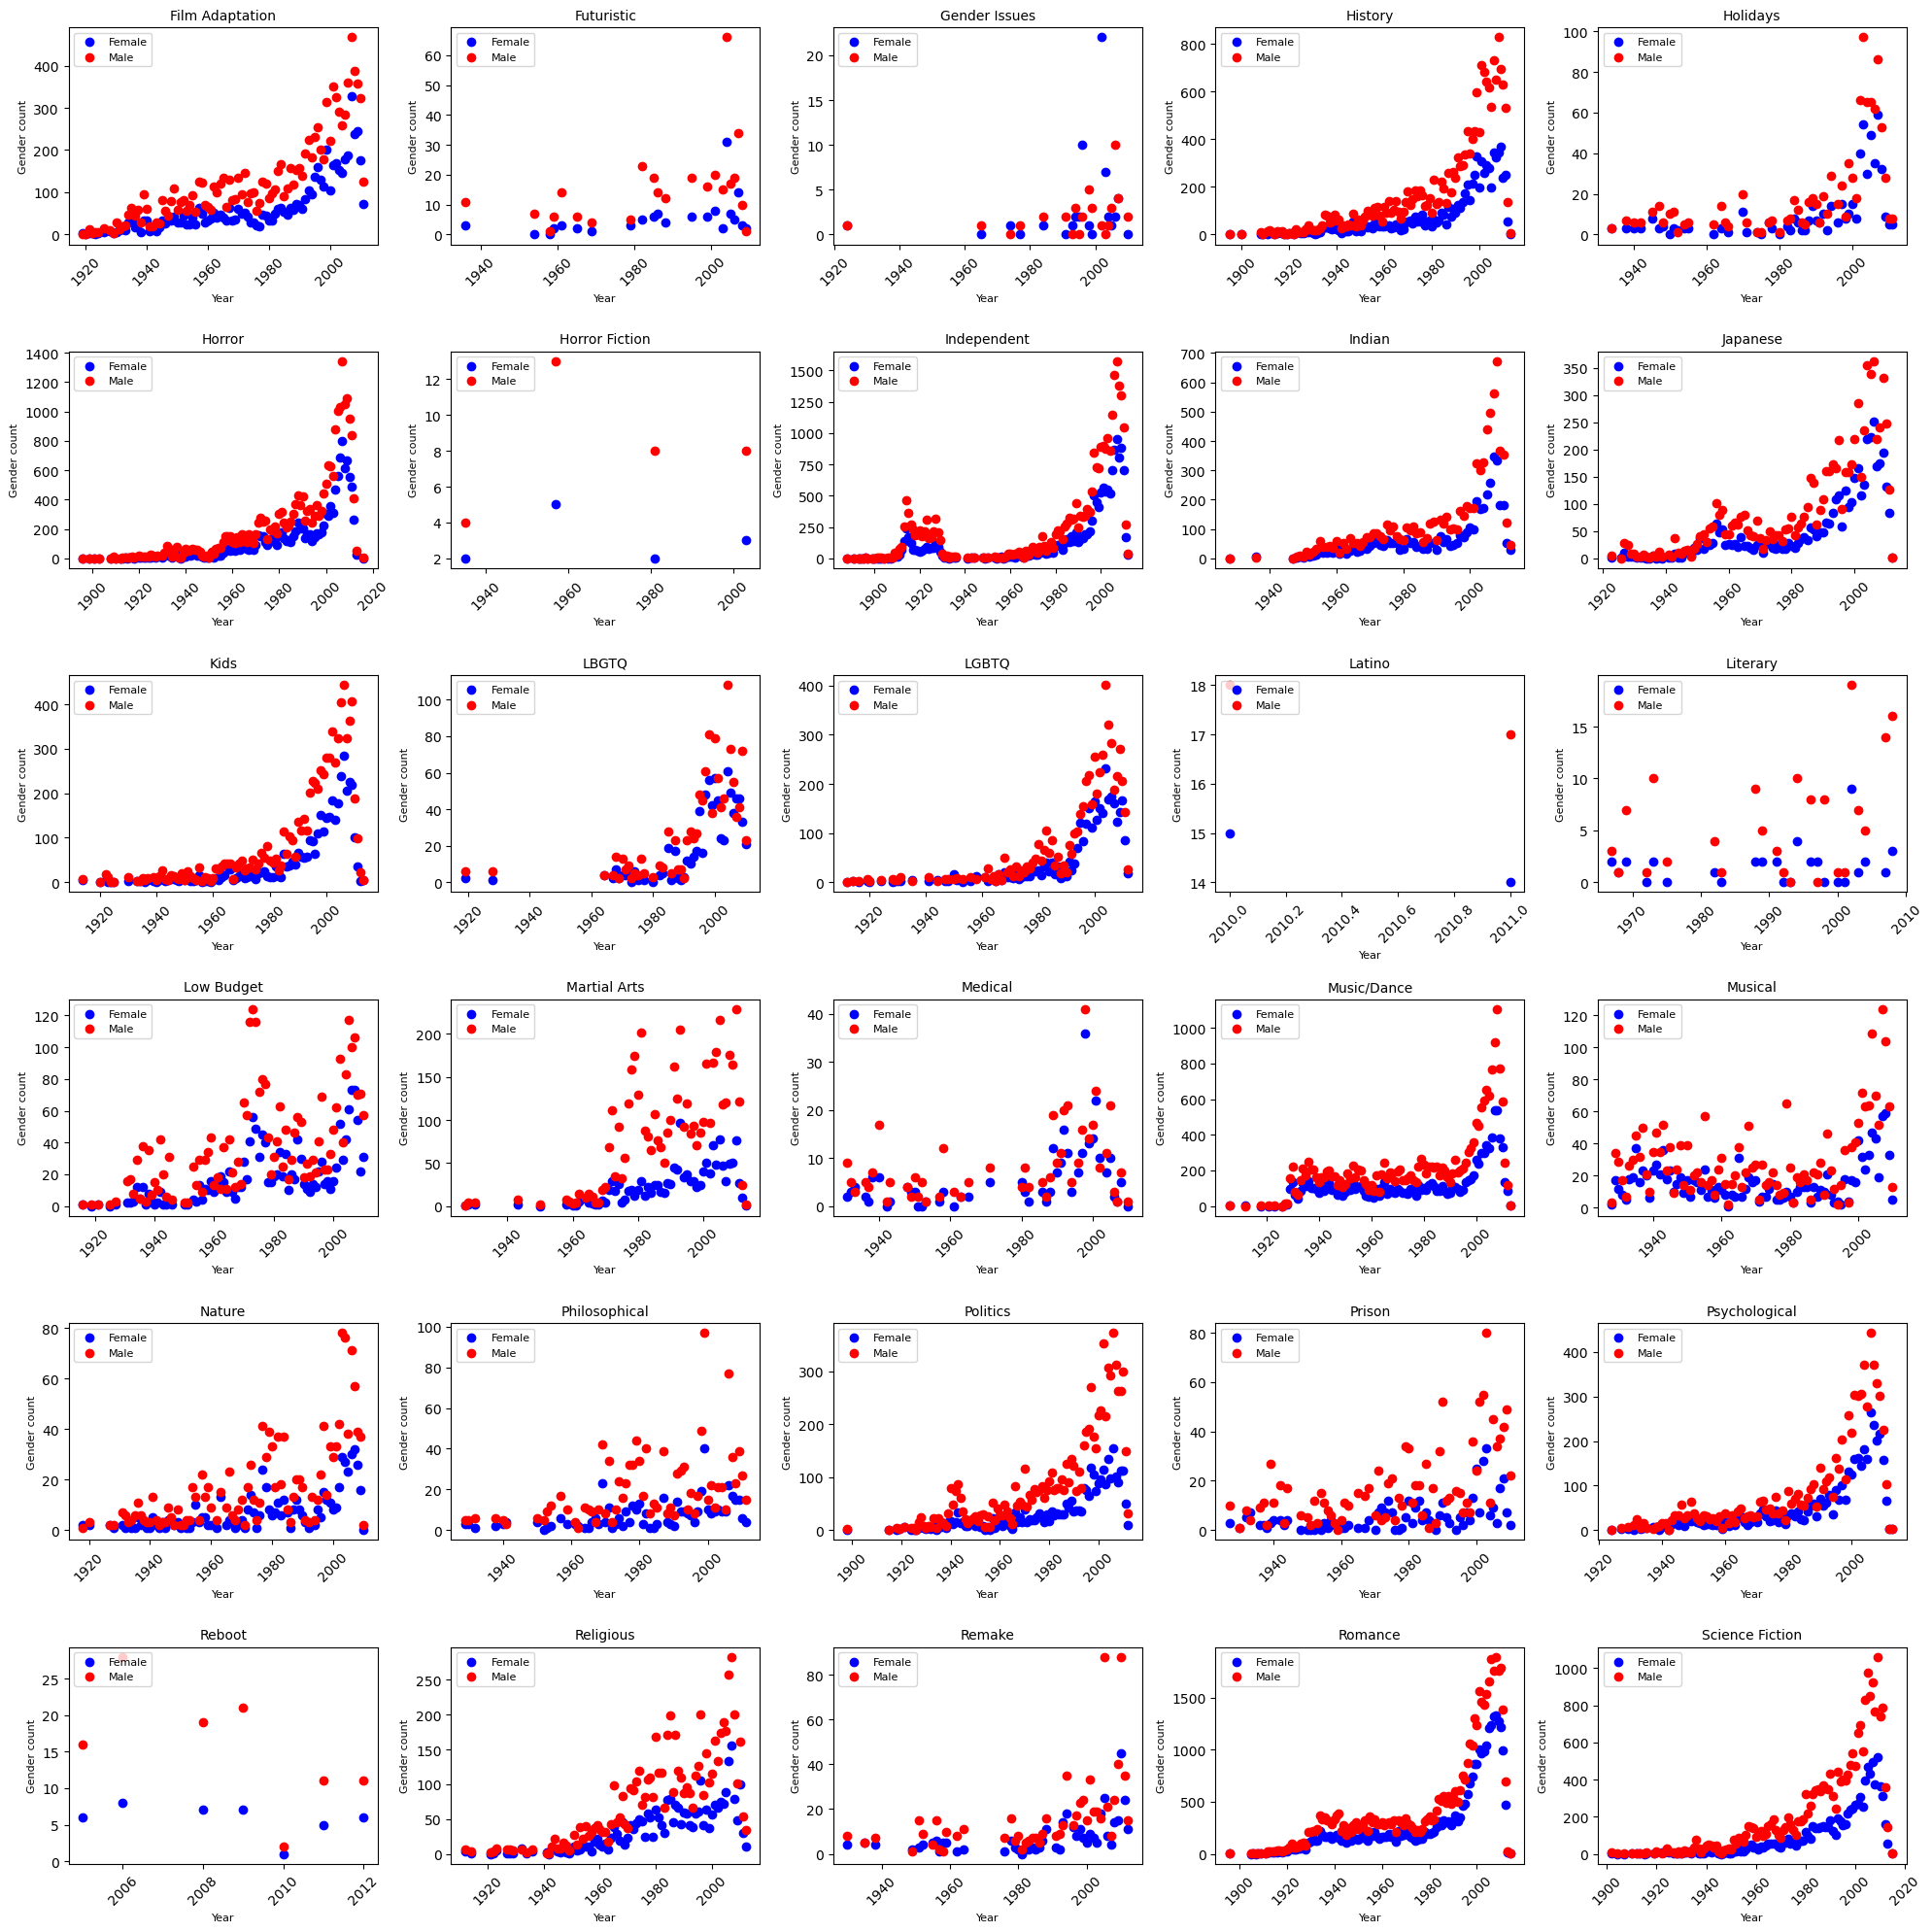

In [106]:
plot_2 = plot_genres(character_meta_genre_year_final, 30, 60)

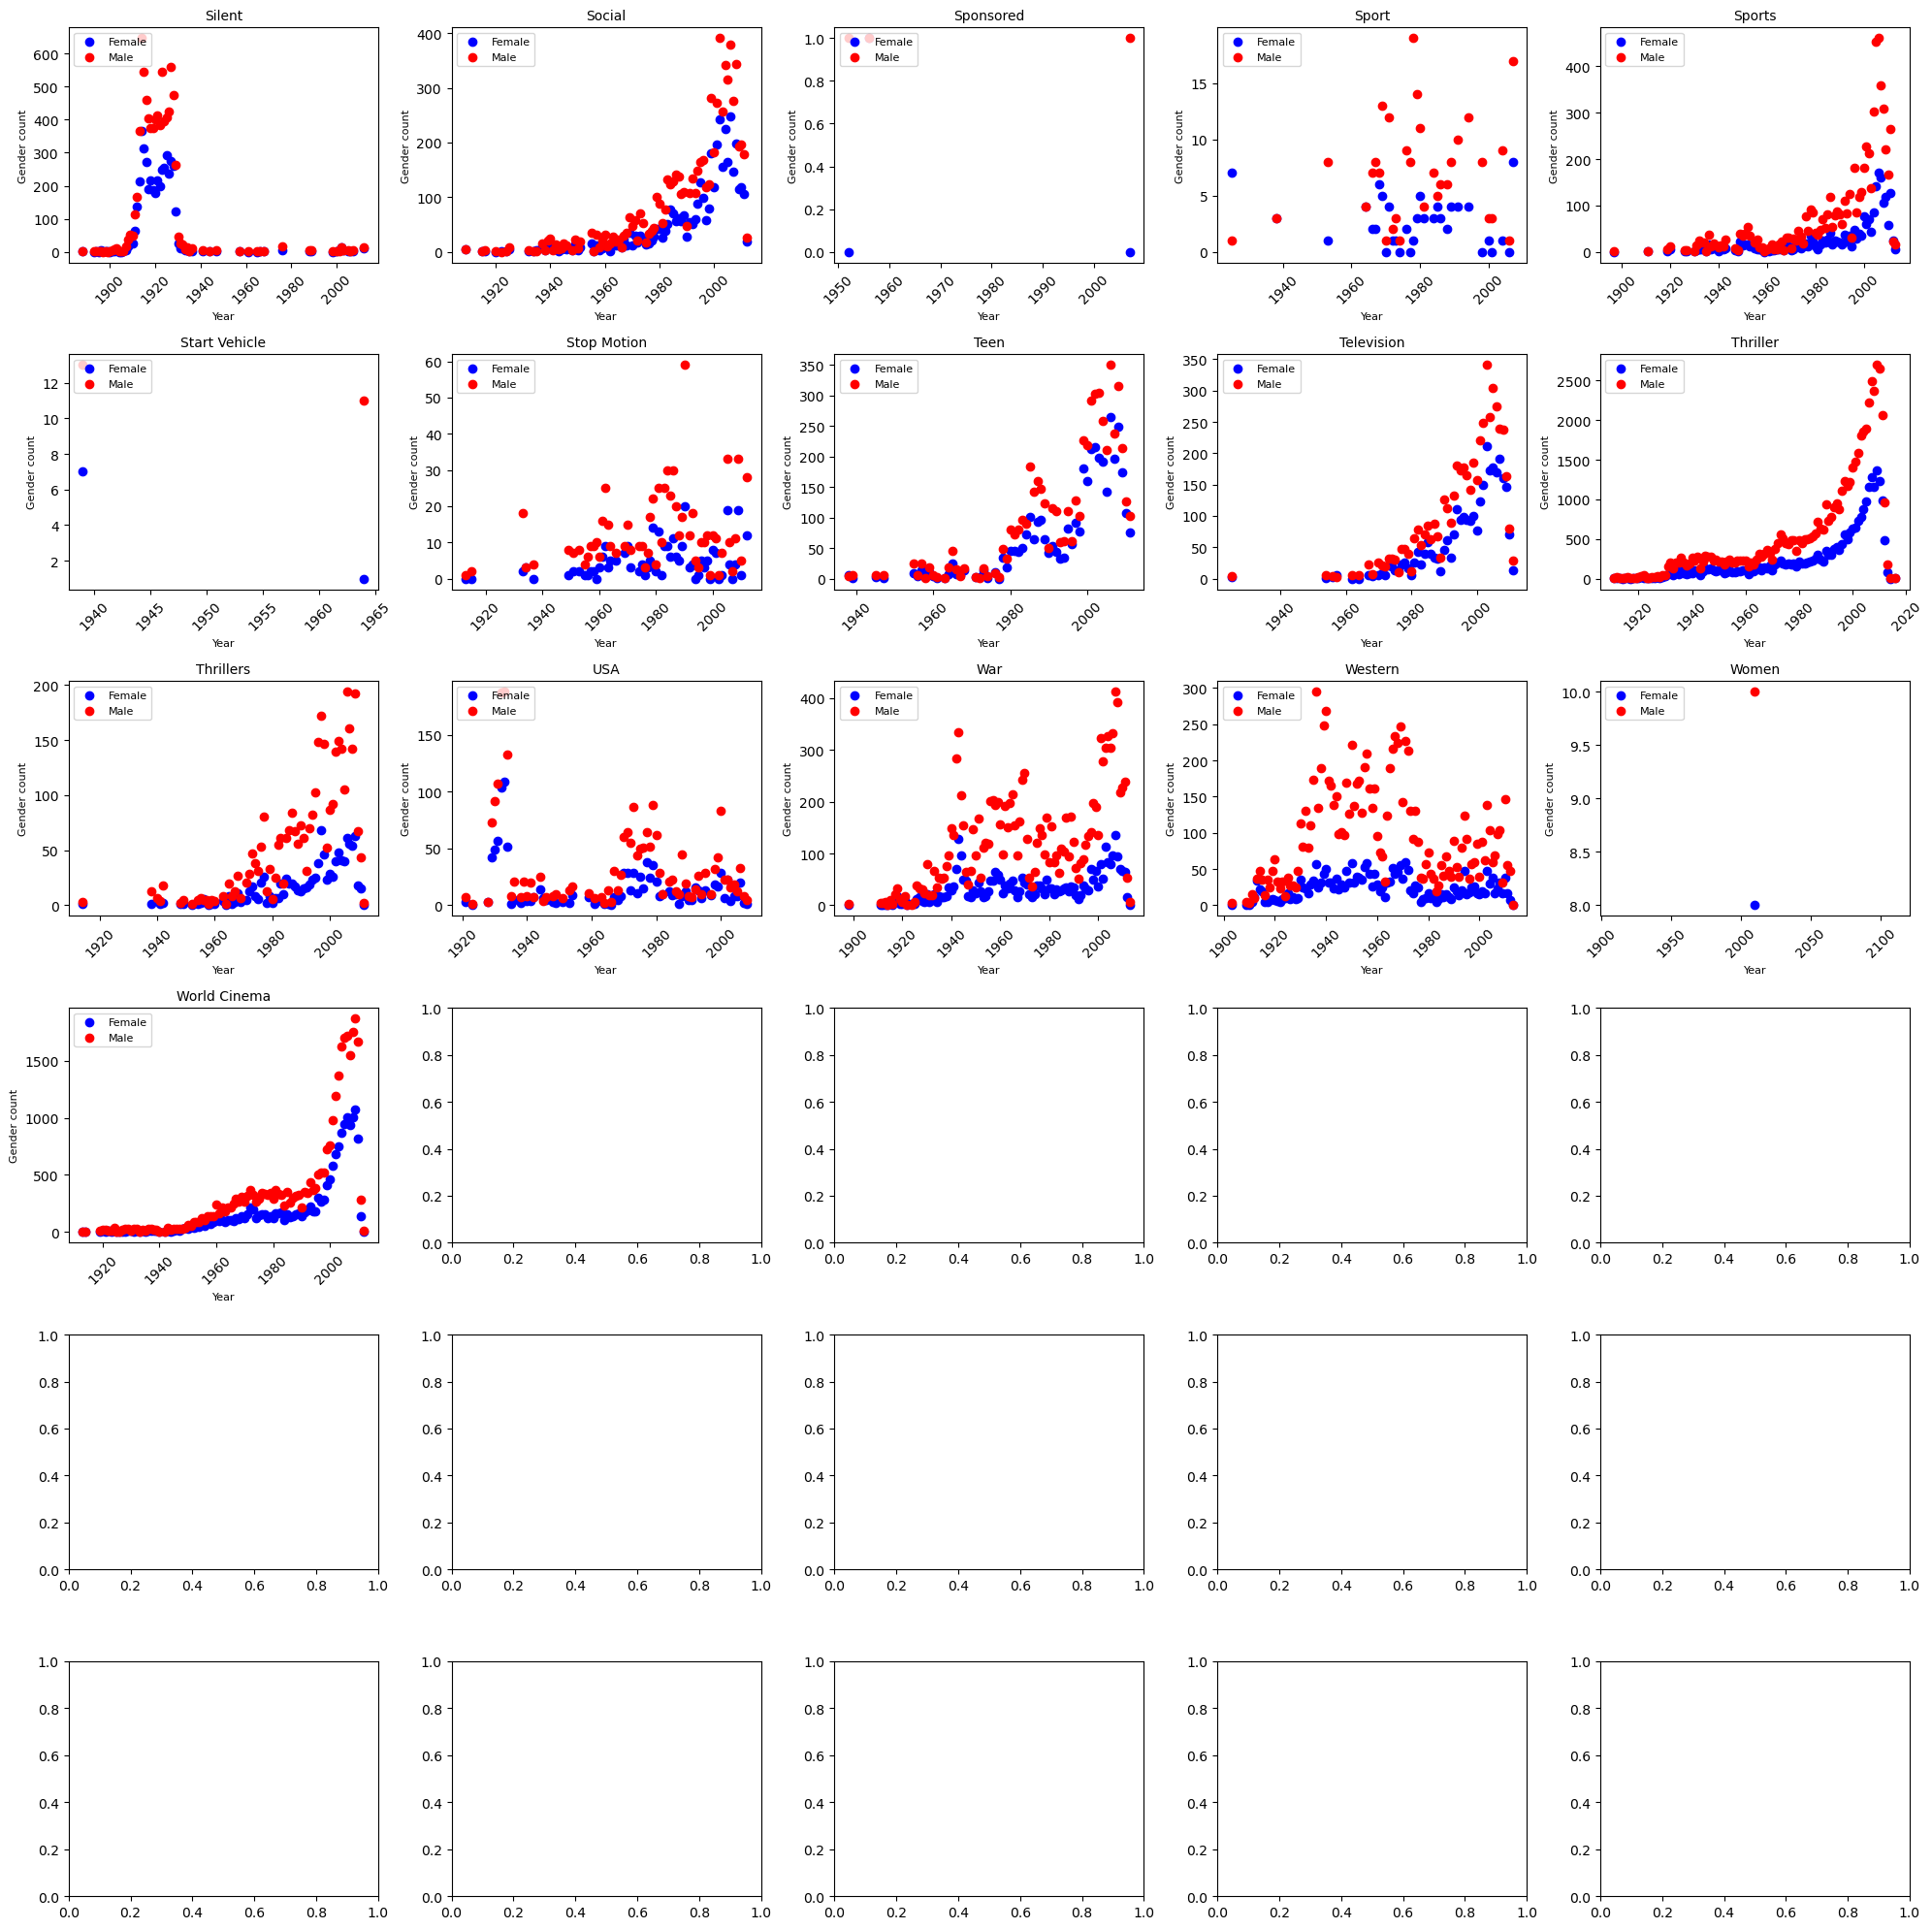

In [107]:
plot_3 = plot_genres(character_meta_genre_year_final, 61, 77)